In [1]:
# importing rampy
import rampy as rp
# and for numpy we will respect the usual name:ß
import numpy as np
# for matplotlib
import matplotlib.pyplot as plt
from pydantic import BaseModel
import matplotlib.pyplot as plt
from glob import glob

from typing import List

In [2]:
class XRange(BaseModel):
    lower_limit:float
    higher_limit:float

def _select_range(x_range:XRange, data:np.array) -> np.array:
    cond1 = data[:,0] > x_range.lower_limit
    cond2 = data[:,0] < x_range.higher_limit
    cond = cond1 & cond2
    data = data[cond].copy()
    return data

def _single_load_data(filename:str, x_range:XRange=None,  basepath:str="./data") -> np.array:
    # from glob import glob
    import os
    filepath = os.path.join(basepath, f"{filename}")
    if(os.path.exists(filepath) == False):
        raise FileExistsError(f"{filepath=} is not exists")
    spectrum = np.genfromtxt(filepath)
    # Flip X-axis
    spectrum = rp.flipsp(spectrum)
    if(x_range != None):
        assert isinstance(x_range, XRange), f"limit_x must be `XRange`"
        spectrum = _select_range(x_range=x_range, data=spectrum)
    return spectrum

def load_data(filenames:List[str], x_range:XRange=None, basepath:str="./data") -> np.array:
    import os
    spectrums = []
    for f in filenames:
        # print(f)
        spectrum = _single_load_data(filename=f, x_range=x_range, basepath=basepath)
        spectrums.append(spectrum)

    # avergae
    spectrums = np.array(spectrums)
    spectrums = spectrums.mean(axis=0)
    return spectrums

In [3]:
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import savgol_filter, general_gaussian

def modified_z_score(ys):
    ysb = np.diff(ys) # Differentiated intensity values
    median_y = np.median(ysb) # Median of the intensity values
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ysb]) # median_absolute_deviation of the differentiated intensity values
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in ysb] # median_absolute_deviationmodified z scores
    return modified_z_scores
    
# The next function calculates the average values around the point to be replaced.
def despike(y:np.array,window_size:int=20) -> np.array:
    ma = window_size//2
    threshold = 7 # binarization threshold
    spikes = abs(np.array(modified_z_score(y))) > threshold
    # print(spikes.any())
    y_out = y.copy()
    for i in np.arange(len(spikes)):
        if spikes[i] != 0:
            w = np.arange(i-ma,i+1+ma)
            we = w[spikes[w] == 0]
            y_out[i] = np.mean(y[we])
    return y_out


# We need the following packages here:
from scipy import sparse
from scipy.sparse.linalg import spsolve

# Parameters for this case:
lam = 10000000 # smoothness
p = 0.05 # asymmetry
# Baseline stimation function:
def baseline_als(y, lam, p, n_epoch=100) -> np.array:
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(n_epoch):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    corrected_y = y.copy() - z.copy()
    return corrected_y, z


In [4]:
glucoses = [0,50,100,150,200,300,400,500]
spectrums = []
x_range = XRange(lower_limit=600, higher_limit=1500)
for glucose in glucoses:
    filelist = glob(f"./data/{glucose}_*")
    # print(filelist)
    specturm = load_data(filenames=filelist, x_range=x_range, basepath="")
    spectrums.append(specturm)


178.48929915167957
179.19141616018558
187.87568808767585
177.43478096874875
175.75631087527336
169.00198602786594
175.7062057638138
162.9838769390002


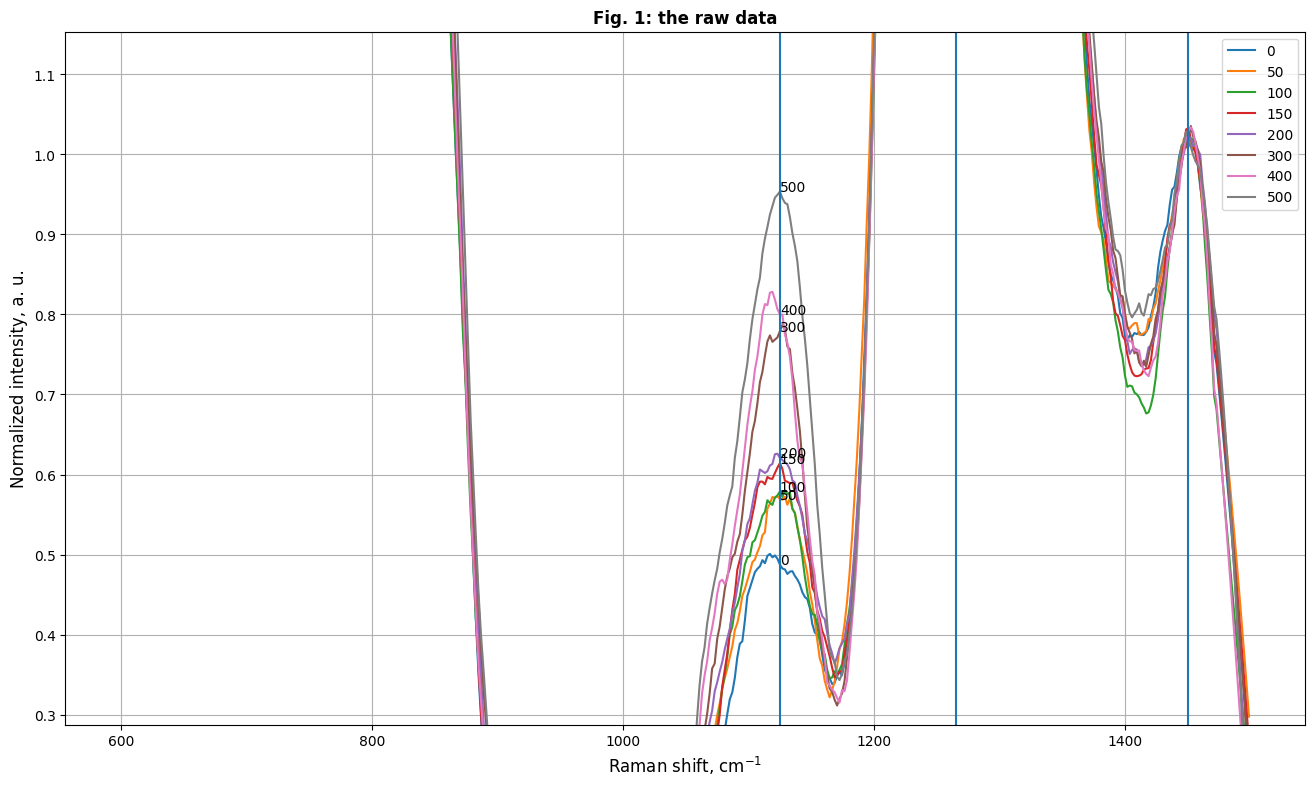

In [5]:
fig,ax = plt.subplots(figsize=(16,9))

ymin = np.inf
ymax = -1 * np.inf
ymin_1125 = np.inf
ymax_1125 = -1 * np.inf
# need to define some fitting regions for the spline
roi1 = np.array([[0, 1500]])
roi2 = np.array([[1245, 1285],[1430, 1470]])


for glucose,spectrum in zip(glucoses, spectrums):
    x = spectrum[:,0].copy()
    y = spectrum[:,1].copy()
    # We did not detect any spike
    y = despike(y, window_size=10)
    y, baseline = baseline_als(y, lam=lam, p=p)

    
    # y, base_poly = rp.baseline(x, y, roi1, 'rubberband', polynomial_order=2)
    # y, base_poly = rp.baseline(x, y, roi2, 'rubberband', polynomial_order=2)
    # # print(y[:,0].shape)
    y = savgol_filter(y.copy(), window_length=30, polyorder=2, deriv=0)
    # y_1450 = y[(x > 1449) & (x < 1451)][0]
    y_1450 = y[(x > 1440) & (x < 1460)].mean()
    print(y_1450)
    y = y/y_1450
    ax.plot(x,y,markersize=1, label=glucose)
    txt_pos_y = y[(x > 1124) & (x < 1126)][0]
    txt_pos_x = 1125
    ax.text(x=txt_pos_x, y=txt_pos_y, s=str(glucose))
    # spectrum[:,1] = rp.smooth(spectrum[:,0],spectrum[:,1], method='savgol', window_length=15, polyorder=2)
    # ax.plot(spectrum[:,0],spectrum[:,1],markersize=1, label=glucose, c=color_map[glucose])

    if y.max() > ymax: ymax = y.max()
    if y.min() < ymin: ymin = y.min()
    if txt_pos_y > ymax_1125: ymax_1125 = txt_pos_y
    if txt_pos_y < ymin_1125: ymin_1125 = txt_pos_y

ax.set_xlabel("Raman shift, cm$^{-1}$", fontsize = 12)
ax.set_ylabel("Normalized intensity, a. u.", fontsize = 12)
ax.set_title("Fig. 1: the raw data",fontsize = 12,fontweight="bold")
ax.vlines(x=1125, ymax=ymax, ymin=ymin)
ax.vlines(x=1265, ymax=ymax, ymin=ymin)
ax.vlines(x=1450, ymax=ymax, ymin=ymin)
ax.set_ylim(ymin=ymin_1125-0.2, ymax=ymax_1125+0.2)
#ax.set_xlim(xmax=1300, xmin=1000)
ax.grid()
ax.legend()
plt.show()